# Mall Customer Segmentation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv('Mall_Customers.csv')

In [5]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
df.shape

(200, 5)

## 1. Exploratory Data Analysis

In [8]:
df = df.drop('CustomerID', axis=1)

In [9]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


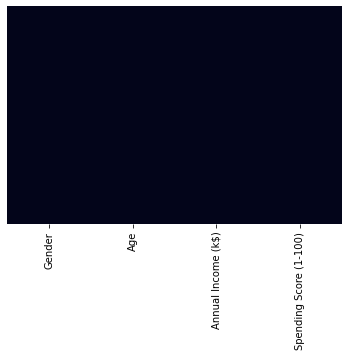

In [10]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False)
plt.show()

#### What is the distribution of age groups, annual income, and spending score of shoppers?

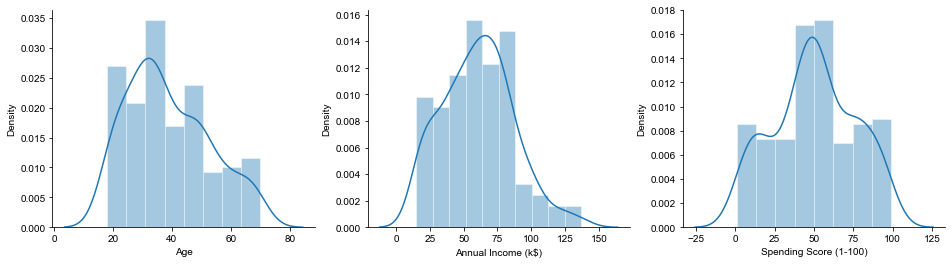

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
sns.set_style('ticks')
sns.distplot(df['Age'], ax=ax[0])
sns.distplot(df['Annual Income (k$)'], ax=ax[1])
sns.distplot(df['Spending Score (1-100)'], ax=ax[2])
sns.despine()
plt.show()

Observations:

<li> Most shoppers are between the age of 30-40. </li>
<li> Most shoppers have an annual income of 50-80 K. </li>
<li> Most shoppers have a spending score of approximately 40-60. </li>

#### How many percent of shoppers are males and females? What's the age of each gender, how much does each gender roughly spend, what's the annual income for each gender?

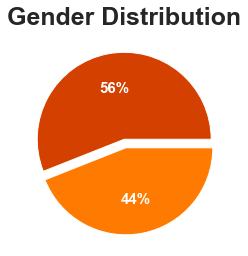

In [12]:
pop_counts = df['Gender'].value_counts()

plt.pie(pop_counts, autopct='%1.0f%%' , colors=['#d44000','#ff7a00'] , 
        labels=['Female','Male'] , explode =[0, 0.1] ,textprops=dict(color='w', fontsize=15 , fontweight='bold'))
plt.title("Gender Distribution", fontsize=25, fontweight='bold')
plt.show()

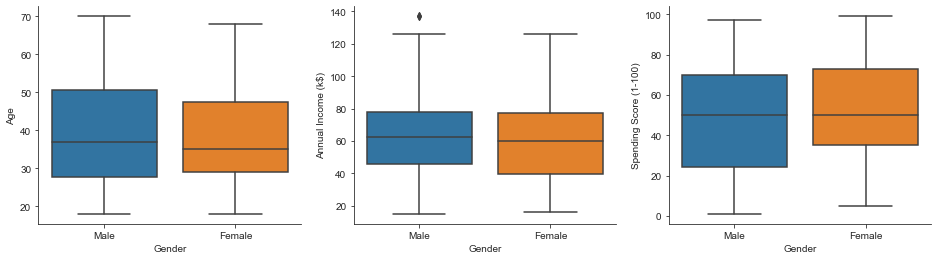

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
sns.set_style('ticks')
sns.boxplot(x=df['Gender'], y=df['Age'], ax=ax[0])
sns.boxplot(x=df['Gender'], y=df['Annual Income (k$)'], ax=ax[1])
sns.boxplot(x=df['Gender'], y=df['Spending Score (1-100)'], ax=ax[2])
sns.despine()
plt.show()

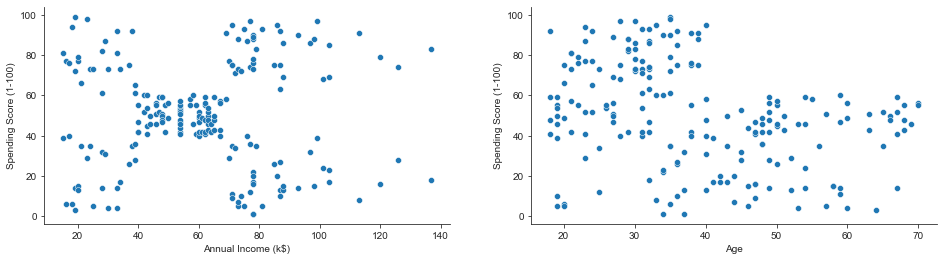

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
sns.set_style('ticks')
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, ax=ax[0])
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=df, ax=ax[1])
sns.despine()
plt.show()

## 2. Clustering Analysis

### 2.1 Scaling Data

In [27]:
data = df.copy()
age_spending = data[['Age','Spending Score (1-100)']]
income_spending = data[['Annual Income (k$)', 'Spending Score (1-100)']]

In [47]:
age_scaler = StandardScaler()
age_scaler.fit(age_spending)
age_spending = age_scaler.fit_transform(age_spending)
age_spending[:,1]

array([-0.43480148,  1.19570407, -1.71591298,  1.04041783, -0.39597992,
        1.00159627, -1.71591298,  1.70038436, -1.83237767,  0.84631002,
       -1.4053405 ,  1.89449216, -1.36651894,  1.04041783, -1.44416206,
        1.11806095, -0.59008772,  0.61338066, -0.82301709,  1.8556706 ,
       -0.59008772,  0.88513158, -1.75473454,  0.88513158, -1.4053405 ,
        1.23452563, -0.7065524 ,  0.41927286, -0.74537397,  1.42863343,
       -1.7935561 ,  0.88513158, -1.7935561 ,  1.62274124, -1.4053405 ,
        1.19570407, -1.28887582,  0.88513158, -0.93948177,  0.96277471,
       -0.59008772,  1.62274124, -0.55126616,  0.41927286, -0.86183865,
        0.5745591 ,  0.18634349, -0.12422899, -0.3183368 , -0.3183368 ,
        0.06987881,  0.38045129,  0.14752193,  0.38045129, -0.20187212,
       -0.35715836, -0.00776431, -0.16305055,  0.03105725, -0.16305055,
        0.22516505,  0.18634349,  0.06987881,  0.34162973,  0.03105725,
        0.34162973, -0.00776431, -0.08540743,  0.34162973, -0.12

In [29]:
income_scaler = StandardScaler()
income_scaler.fit(income_spending)
income_spending = income_scaler.fit_transform(income_spending)

### 2.2 KMeans Clustering

In [37]:
def plot_distortions(data, title, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)
    
    plt.plot(range(1, max_clusters+1), distortions, marker='o')
    plt.title(title)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortions')
    plt.grid()
    plt.show()

In [56]:
def plot_clusters(data, yres, plt_clusters=False):
    x_center=[]
    y_center=[]
    for cluster in set(yres):
        x = data[yres==cluster,0]
        y = data[yres==cluster,1]
        x_center.append(np.mean(x))
        y_center.append(np.mean(y))
        plt.scatter(x, y, marker='s', s=25, label=f'Cluster {cluster}')
        
    if plt_clusters:
        plt.scatter(x_center, y_center, marker='o', c='red')
        
    plt.legend()
    plt.grid()
    plt.show()


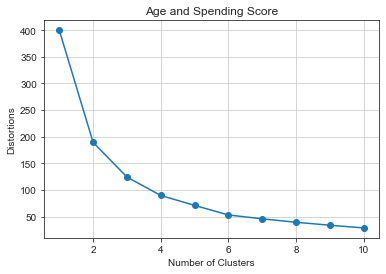

In [38]:
plot_distortions(age_spending, title='Age and Spending Score')

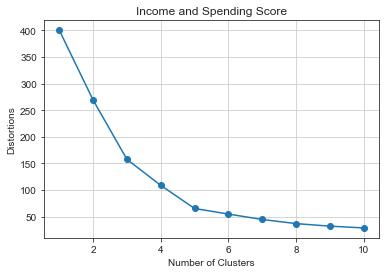

In [39]:
plot_distortions(income_spending, title='Income and Spending Score')

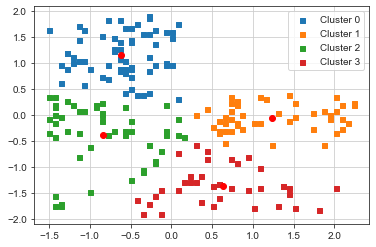

In [58]:
km = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=0)
age_km = km.fit_predict(age_spending)
plot_clusters(age_spending, age_km, plt_clusters=True)

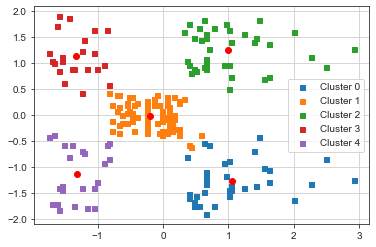

In [59]:
km = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=0)
income_km = km.fit_predict(income_spending)
plot_clusters(income_spending, income_km, plt_clusters=True)